# Basic setup

Here we will import the `pyspark` module and set up a `SparkSession`.  By default, we'll use a `SparkSession` running locally, with one Spark executor for every core on the local machine.  You can change this to run against a Spark cluster by replacing `local[1]` with the URL of the Spark master.


In [1]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.master("local[1]").getOrCreate()
sc = spark.sparkContext

## Creating random data

We'll start by creating some uniformly-distributed random data with which to demonstrate various machine-learning techniques.  Note that we're choosing a data set size that will be possible to plot, not that will make for an interesting problem.

In [2]:
from pyspark.sql.functions import array, column, rand, udf
from pyspark.ml.linalg import Vectors, VectorUDT
as_vector = udf(lambda l: Vectors.dense(l), VectorUDT())

randomDF = spark.range(0, 2048).select((rand() * 2 - 1).alias("x"), (rand() * 2 - 1).alias("y")).select(column("x"), column("y"), as_vector(array(column("x"), column("y"))).alias("features"))

## Setting up plotting

We'll now set up the `seaborn` library to plot into our notebook and do a scatter plot of our random data.

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
import numpy as np
sns.set(color_codes=True)

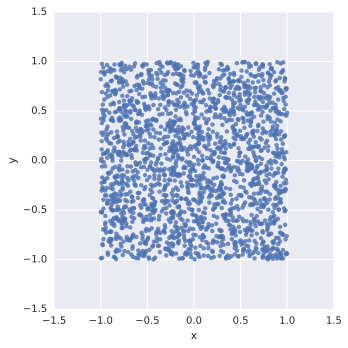

In [4]:
_ = sns.lmplot("x", "y", randomDF.toPandas(), fit_reg=False, scatter=True)

# Clustering

Machine learning practitioners often speak of two types of learning:  _supervised_ learning, in which training data are _labeled_, and _unsupervised_ leanring, in which training data are unlabeled.  We will examine some supervised learning tasks later in this tutorial, but first we will look at a simple unsupervised learning task:  _clustering_, or finding groupings of similar objects.

There are several algorithms for clustering, but one of the easiest to understand is [_k-means clustering_](https://en.wikipedia.org/wiki/K-means_clustering), which identifies _k_ cluster centers and learns a placement of these centers so as to minimize the variance from samples to their nearest cluster centers.  While we certainly don't have enough data to justify parallel or distributed execution, we'll use Spark's k-means implementation so that you can become familiar with it.

In [5]:
from pyspark.ml.clustering import KMeans

K = 7
SEED = 0xdea110c8

kmeans = KMeans().setK(K).setSeed(SEED).setFeaturesCol("features")
model = kmeans.fit(randomDF)

That's all we need to do to find `K` cluster centers!  Now we'll use the model to add a column to `randomDF` with the number of the closest cluster center for each row.

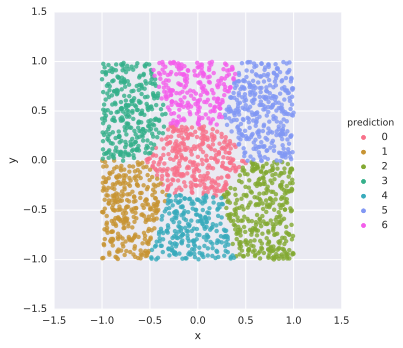

In [6]:
withPredictions = model.transform(randomDF).select("x", "y", "prediction")

_ = sns.lmplot("x", "y", withPredictions.toPandas(), fit_reg=False, scatter=True, hue="prediction")

We can see how many observations are in each cluster by using data frame aggregate functions:

In [7]:
from pyspark.sql.functions import count
withPredictions.groupBy("prediction").agg(count("prediction")).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         1|              296|
|         6|              225|
|         3|              302|
|         5|              335|
|         4|              240|
|         2|              342|
|         0|              308|
+----------+-----------------+



### Try it out yourself

Try running the code with a different number of cluster centers and seeing how the plot changes!

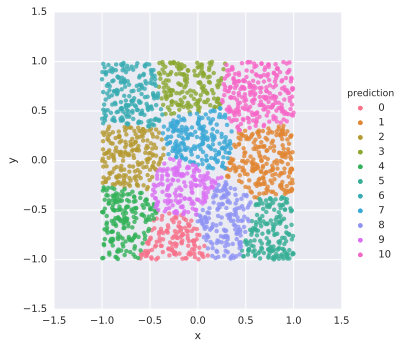

In [8]:
def cluster_and_plot(df, k, seed=0xdea110c8):
    kmeans = KMeans().setK(k).setSeed(seed).setFeaturesCol("features")
    withPredictions = kmeans.fit(df).transform(df).select("x", "y", "prediction")
    return sns.lmplot("x", "y", withPredictions.toPandas(), fit_reg=False, scatter=True, hue="prediction")

_ = cluster_and_plot(randomDF, 11)

### Sidebar:  parameters and hyperparameters

You may have noticed that when we trained the k-means model above, we supplied some parameters to Spark's `KMeans` object.  Some of these simply told Spark which columns of our data frame contained the feature data to train on, but others, like _k_, affected the training process and the output of the model independently of the input data.  We call these settings _hyperparameters_, which we contrast with the _parameters_ of a given model, which are learned from the data (e.g., in this case, the coordinates of cluster centers).

### Sidebar:  dimensionality, similarity, and distance

You may have noticed that our input data is two-dimensional, and you may suspect that many machine learning problems involve higher-dimensional data.  You're right!  (Although there are interesting two-dimensional applications for clustering, like deciding where to put new retail locations given a database of potential customers.)  We're using two dimensions here because it is easy to visualize and most people have pretty good intuitions about two-dimensional data.  However, it is important to note that most machine learning techniques generalize to arbitrarily many dimensions.  Put another way, you can compare objects with the same number of dimensions, no matter how large that number is.

k-means clustering in particular uses [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) (which is defined for objects of arbitrary dimensionality) to determine how similar two objects are, but for some problems, it might make sense to use a different distance metric.  Euclidean distance makes sense for many, but not all applications, and it may be less useful for very high-dimensional data than other metrics (since points in high-dimensional space are generally sparser than points on the plane).  Some other metrics that are interesting include:

* [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry)
* [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity), which compares angles between points and is especially useful for comparing large sparse vectors
* The [Jaccard coefficient](https://en.wikipedia.org/wiki/Jaccard_index), which characterizes the similarity of sets with finite domains

We'll discuss dimensionality more later in the notebook, so stay tuned!

# Classification

The second family of techniques we'll look at is are supervised learning techniques that are all types of _classification_.  Specifically, we're going to show an algorithm for _binary classification_, where there are two sorts of labels.  The classifier we'll use will try and cut the feature space in two parts along a linear boundary so that the objects on one side of the boundary are likely to have one label value and that those on the other are likely to have the other value.  We'll start by using a Spark user-defined function to generate synthetic labels for our random data:


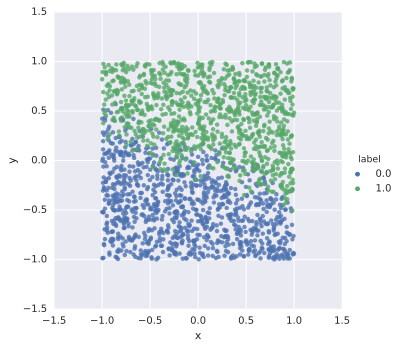

In [9]:
from pyspark.sql.types import DoubleType
from random import uniform

synthetic_label = udf(lambda v: (abs(v[0]) * v[0]) + (v[1] * 2) + uniform(-0.5, 0.5) > 0 and 1.0 or 0.0, DoubleType())

labeledDF = randomDF.withColumn("label", synthetic_label(randomDF["features"]))
_ = sns.lmplot("x", "y", labeledDF.select("x", "y", "label").toPandas(), hue="label", fit_reg=False)

### Sidebar:  using synthetic data

If you look at the function we use to generate synthetic labels, you'll notice that it takes a  simple function (`(abs(x) * x) + 2y`)  and adds some uniformly-distributed noise.  You may have the (totally reasonable) philosophical objection that it is trivial to identify a separation of the feature space to differentiate between labels, since we constructed the labels to be separable.  These techniques will still work for real data, though, and using simple techniques to construct synthetic data makes the tutorial easier to follow!

## Logistic regression

Logistic regression is a technique for binary or multi-class classification.  We will use it for the former here.  We will also divide our training data into training and test sets so we can evaluate how well our classifier works on data it has never seen before.

In [10]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()
training, test = labeledDF.randomSplit([.7,.3])

lr_model = lr.fit(training)

lr_predictions = lr_model.transform(labeledDF)

Unlike the k-means predictions, the logistic regression predictions include a probability.

In [11]:
lr_predictions.printSchema()

root
 |-- x: double (nullable = false)
 |-- y: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



We can now plot the predictions:

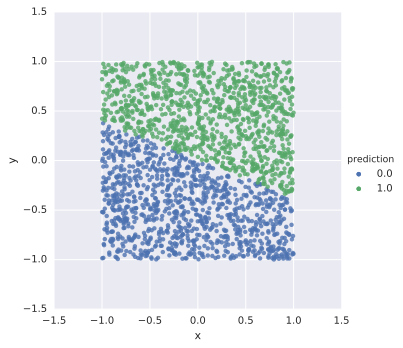

In [12]:
_ = sns.lmplot("x", "y", lr_predictions.select("x", "y", "prediction").toPandas(), hue="prediction", fit_reg=False)

We can also plot just the mispredicted samples:

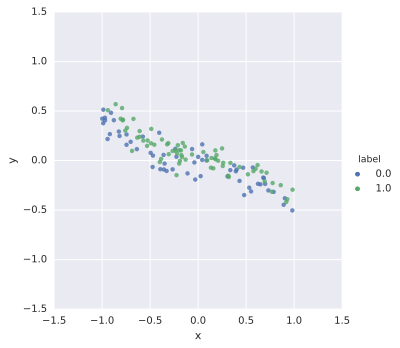

In [13]:
_ = sns.lmplot("x", "y", lr_predictions.filter(lr_predictions["prediction"] != lr_predictions["label"]).select("x", "y", "label").toPandas(), hue="label", fit_reg=False).set(xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))

## Characterizing classifier performance

It should be clear that merely being right most of the time isn't necessarily a great measure of how our classifier is doing.  (If we were trying to predict a condition that occured in 5% of the population, a trivial classifier that always returned "no" would be right 95% of the time!)

One way to visualize the performance of a binary classifier is with a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), which shows the actual values in rows and the predicted values in columns, so you can see true positives and true negatives along one diagonal and false positives and false negatives along the other.  We can make such a matrix with data frame queries:


In [14]:
from pyspark.sql.functions import column, sum, when
lrp = lr_predictions
lr_predictions.select("label", when(lrp["prediction"] == 0.0, 1).otherwise(0).alias("p0"), when(lrp["prediction"] == 1.0, 1).otherwise(0).alias("p1")).groupBy("label").agg(sum(column("p0")).alias("predicted 0"), sum(column("p1")).alias("predicted 1")).show()

+-----+-----------+-----------+
|label|predicted 0|predicted 1|
+-----+-----------+-----------+
|  0.0|        971|         67|
|  1.0|         62|        948|
+-----+-----------+-----------+



Another way to visualize our performance is with a [receiver operating characteristic curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) ("ROC curve" for short).  This is a useful way to compare several classifiers (or several thresholds for deciding that objects should be labeled `1.0`), as it plots the true positive rate against the false positive rate.  We can construct an ROC curve with Spark and Seaborn as follows:

In [15]:
summary = lr_model.summary
roc = summary.roc
roc = roc.select(roc["FPR"].alias("False Positive Rate"), roc["TPR"].alias("True Positive Rate")).toPandas()

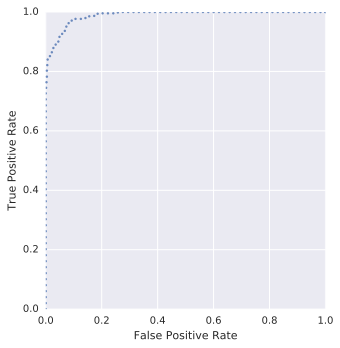

In [16]:
_ = sns.lmplot("False Positive Rate", "True Positive Rate", roc, fit_reg=False, scatter=True, scatter_kws={'marker':'1', 's':6}).set(xlim=(0,1), ylim=(0,1))